<a href="https://colab.research.google.com/github/DeepLearningSaeid/Grad/blob/main/Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# This code installs the Autokeras library and imports the required libraries.
#  Autokeras is an open-source library that uses Bayesian optimization and reinforcement learning to optimize machine learning models. 
#  The timeit library is used to measure the execution time of code snippets. The numpy library is used for scientific computing with Python. 
#  The train_test_split function from sklearn.model_selection is used to split the dataset into training and test sets. 
#  The matplotlib library is used for data visualization. 
#  The Model, Sequential, Input, Embedding, Dense, concatenate, Dropout, Flatten, and Activation classes from the keras.layers module 
#  are used to define the architecture of a neural network. The backend module from keras is used to access the functions from the backend (e.g., TensorFlow). 
#  The get_custom_objects function from keras.utils.generic_utils is used to register custom objects for serialization and deserialization. 
#  The np_utils, to_categorical, and plot_model functions from keras.utils 
#  are used for data preprocessing, creating a categorical representation of data, and visualizing the model architecture. 
#  The random seed is set to 110 to ensure reproducibility of results.

# Install Autokeras library
!pip install autokeras

# Import required libraries
import autokeras as ak
import timeit
import numpy as np
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Dense, concatenate, Dropout, Flatten, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.utils import np_utils, to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist


# Set random seed
np.random.seed(110)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
# This code defines a number of custom activation functions that can be used in a Keras model. 
# The get_custom_objects function is used to retrieve a dictionary mapping names to custom objects (such as functions),
# and the update function is used to add the custom activation functions to this dictionary.

# Here is a brief description of each function:

#     x_1: This function raises the input to the power of 1, which is equivalent to returning the input as is.
#     x_2: This function returns the square of the input divided by 2.
#     x_2_: This function returns the square of the input divided by 24.
#     x_2__: This function returns the square of the input divided by 720.
#     x_2___: This function returns the square of the input divided by 40320.

# After these functions are defined, they can be used as activation functions in a Keras model 
# by using the names 'X_1', 'X_2', 'X_2_', 'X_2__', and 'X_2___', respectively. 
# For example, to use the x_2 function as an activation, you would use Dense(hidden_dimention, activation='X_2').

#Define custom activation functions

def x_1(x):
# """Returns x^1"""
  return K.pow(x, 1)
  
# Register x_1 as a custom activation function
get_custom_objects().update({'X_1': Activation(x_1)})

def x_2(x):
# """Returns (x^2)/2"""
  return (K.pow(x, 2)) / 2

# Register x_2 as a custom activation function
get_custom_objects().update({'X_2': Activation(x_2)})

def x_2_(x):
# """Returns (x^2)/24"""
  return (K.pow(x, 2)) / 24

# Register x_2_ as a custom activation function
get_custom_objects().update({'X_2_': Activation(x_2_)})

def x_2__(x):
# """Returns (x^2)/720"""
  return (K.pow(x, 2)) / 720

# Register x_2__ as a custom activation function
get_custom_objects().update({'X_2__': Activation(x_2__)})

def x_2___(x):
# """Returns (x^2)/40320"""
  return (K.pow(x, 2)) / 40320

# Register x_2___ as a custom activation function
get_custom_objects().update({'X_2___': Activation(x_2___)})

In [35]:
# This code defines a number of functions that can be used for testing purposes. Here is a brief description of each function:

#     power_: This function raises the input to the power of a specified number.
#     sigmoid_array: This function applies the sigmoid function element-wise to the input array.
#     exp_: This function applies the exponential function element-wise to the input array.
#     log_: This function applies the natural logarithm element-wise to the input array.
#     generate_random: This function generates a 2D array of random numbers between 0.01 and 0.99.
#     fun_1: This function returns a combination of the square of the input and the sigmoid of the input.
#     fun_2: This function returns a combination of the fifth power of the input, the sigmoid of the input, the exponential of the input, and the natural 
#      logarithm of the input.
#     fun_3: This function returns a combination of the 20th power of the input, the sigmoid of the input, the exponential of the input, 
#      and the natural logarithm of the input.


def power_(x, n):
    return np.power(x, n)

def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

def exp_(x):
    return np.exp(x)

def log_(x):
    return np.log(x)

def generate_random(shape_1, shape_2):
    temp = np.random.random(shape_1 * shape_2)
    temp = np.random.uniform(low=0.01, high=0.99, size=(shape_1 * shape_2))
    temp1 = temp.reshape(shape_1, shape_2)
    return temp1

def fun_1(x):
    return 1 / 2 * power_(x, 2) - 5 * sigmoid_array(x)

def fun_2(x):
    return 6 * power_(x, 5) - 3 * sigmoid_array(x) + exp_(x) - 9 * log_(x)

def fun_3(x):
    return 22 * power_(x, 20) + sigmoid_array(x) + 2 * exp_(x) + 5 * log_(x)


In [36]:
# This code defines a function plot_loss that creates a single plot with six subplots.
#  Each subplot visualizes the training and test loss for a particular model architecture over the number of epochs.
#  The function takes in the following arguments:

#     size: The maximum value for the y-axis of all subplots.
#     in_1, in_2, ..., in_6: The History objects for the six model architectures.
#     title: The title for each subplot.

# The function first defines a helper function plot_subplot that takes in a subplot number, a History object, and a title,
# and creates a single subplot with the training and test loss for that model architecture. 
# The plot_loss function then calls plot_subplot for each of the six model architectures.

def plot_loss(size, in_1, in_2, in_3, in_4, in_5):
    # Set font size for all subplots
    plt.rcParams.update({'font.size': 12})
    
    def plot_subplot(subplot_num, history, title):
        # Extract training and test loss from history object
        training_loss = history.history['loss']
        test_loss = history.history['val_loss']
        
        # Create list of epochs
        epoch_count = range(1, len(training_loss) + 1)
        
        # Create subplot and plot training and test loss
        plt.subplot(subplot_num)
        plt.plot(epoch_count, training_loss, 'r--')
        plt.plot(epoch_count, test_loss, 'b-')
        
        # Add legend and labels
        plt.legend(['Training Loss', 'Test Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        # Set y-axis limit
        plt.ylim(0, size)
        
        # Add title to subplot
        plt.title(title)
    
    # Create figure with 6 subplots
    plt.figure(figsize=(20, 12))
    
    # Plot training and test loss for each model architecture
    plot_subplot(231, in_1, 'Architecture 1')
    plot_subplot(232, in_2, 'Architecture 2')
    plot_subplot(233, in_3, 'Auto_Keras ')
    plot_subplot(234, in_4, 'Random Search')
    plot_subplot(235, in_5, 'SWAG')


In [37]:
# This function plots the shapes of the input test functions on six subplots. 
# It takes six inputs, each of which is an array containing three arrays. 
# The first array of each input contains the input values of the test function,
#  the second array contains the output values of the test function, 
#  and the third array contains the predicted output values of the test function. 
#  The subplots are arranged in a 2x3 grid and the shapes of the test functions are plotted on each subplot using the scatter function. 
#  The title function is used to label each subplot with the name of the architecture being plotted. 
#  The subplots_adjust function is used to adjust the spacing between subplots. Finally, the show function is used to display the plots.


def plot_shape(in_1,in_2,in_3,in_4,in_5):
    # Set up the plot with a figure size of (20,10)
    plt.figure(figsize=(20,10))
    # Update the font size of the plot to 16
    plt.rcParams.update({'font.size': 16})

    # Plot the first subplot with the input data
    plt.subplot(231)
    plt.scatter(in_1[0], in_1[1])
    plt.scatter(in_1[0], in_1[2])
    plt.title('Architure 1')

    # Plot the second subplot with the input data
    plt.subplot(232)
    plt.scatter(in_2[0], in_2[1])
    plt.scatter(in_2[0], in_2[2])
    plt.title('Architure 2')

    # Plot the third subplot with the input data
    plt.subplot(233)
    plt.scatter(in_3[0], in_3[1])
    plt.scatter(in_3[0], in_3[2])
    plt.title('Auto Keras')

    # Plot the fourth subplot with the input data
    plt.subplot(234)
    plt.scatter(in_4[0], in_4[1])
    plt.scatter(in_4[0], in_4[2])
    plt.title('Random Search')
    
    # Plot the fifth subplot with the input data
    plt.subplot(235)
    plt.scatter(in_5[0], in_5[1])
    plt.scatter(in_5[0], in_5[2])
    plt.title('SWAG')    
    

    # Adjust the subplot layout
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0010, right=0.95, hspace=0.3, wspace=0.18)

    # Show the plot
    plt.show()


In [38]:
# The function plot_ takes a Keras model's training history as input and plots the training loss and test loss over the number of epochs.
#  It uses matplotlib to create the plot and displays it to the user. 
#  The x-axis represents the epoch count, the y-axis represents the loss value, and the training loss is plotted in red with a dashed line and 
#  the test loss is plotted in blue with a solid line. The legend labels the two curves as "Training Loss" and "Test Loss",
#   and the x-axis and y-axis are labeled as "Epoch" and "Loss" respectively. The plot is then displayed to the user using the show function.
def plot_(history):
    # Retrieve the training and test loss values
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Generate epoch count
    epoch_count = range(1, len(training_loss) + 1)

    # Plot the training and test loss
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [39]:
# The function visualize_result takes in a history object, X test data, Y test data, and a model. 
# It first calls the plot_ function to plot the training and test loss over the epochs. 
# It then plots the X test data against the Y test data as a scatter plot. 
# It then generates predictions for the X test data using the model, and plots those predictions against the X test data as a scatter plot.
def visualize_result(history,X_test, Y_test,model):
  # Plot the loss curve
  plot_(history)
  # Scatter plot of the true test data
  plt.scatter(X_test, Y_test)
  # Scatter plot of the model's predicted output
  predict=model.predict(X_test)
  plt.scatter(X_test, predict)
  plt.show()

In [40]:
#Creates dataset
dim_train=1000
dim_test=200

X=generate_random(dim_train,3)
Y=generate_random(dim_train,3)
    
Y[:,0]=fun_1(X[:,0])
Y[:,1]=fun_2(X[:,1])
Y[:,2]=fun_3(X[:,2])
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=1234)

def data_prep(x_train,x_test,y_train,y_test,column):
  X_train=x_train[:,column]
  Y_train=y_train[:,column]
  X_test=x_test[:,column]
  Y_test=y_test[:,column]
  return X_train,Y_train,X_test,Y_test

In [41]:
# This is a Python function called "model_training_visualization" that takes in several inputs:

# model_input: a pre-defined machine learning model
# X_train_1: the input training data
# Y_train_1: the output training data
# X_test_1: the input testing data
# Y_test_1: the output testing data
# number_epo_1: the number of epochs to train the model
# batch_size_: the batch size used during training
# The function performs several actions:

# It uses the timeit library to measure the runtime of the model training process, which starts with the model_input.fit() method and ends after the print("Run Time : %f" % (end - start)) statement
# It makes predictions using the model_input.predict() method on the X_test_1 input data and saves the predictions in the predict variable
# It calls another function called visualize_result() to visualize the results of the model training process. This function likely takes in the training history, testing data, and the model as input.
# It returns a list containing the X_test_1, Y_test_1, predict and history variables
# In summary, the function trains a machine learning model, measures the runtime, makes predictions on a test set, visualizes the results, and returns some output variables.




def model_training_visualization(model_input,X_train_1,Y_train_1,X_test_1,Y_test_1,number_epo_1,batch_size_):
  # Train model
  start = timeit.default_timer()
  history = model_input.fit(X_train_1, Y_train_1, epochs=number_epo, verbose=0, batch_size=batch_size_,
                          validation_data=(X_test_1, Y_test_1))
  end = timeit.default_timer()
  print("Run Time : %f" % (end - start))

  # Make predictions and visualize results
  predict = model_input.predict(X_test_1)
  visualize_result(history, X_test_1, Y_test_1, model_input)
  return [X_test_1, Y_test_1, predict, history]

In [42]:
# Hyper perameters
number_epo=50
input_dim=1
output_dim=1

In [43]:
# This code defines a function called "SWAG()" which creates a neural network model using the Keras library in TensorFlow. 
# The function starts by defining a variable hidden_dimention with the value of 50.

# The function then creates an initializer for the weight and bias of the layers using tf.keras.initializers.RandomNormal with mean 0.1, standard deviation 0.05.

# The function then defines a sequential model using the Sequential() method from the Keras library. It also defines an input layer with shape (input_dim,).

# The function then creates two sets of layers, the first set of layers are created with two dense layers layer_1_x_1 and layer_1_x_2 with 
# the same number of hidden dimensions and activation functions 'X_1' and 'X_2' respectively.
#  The function then concatenates these two layers together using concatenate() method.

# The second set of layers are created with three dense layers layer_x_3_x_4, layer_x_5_x_6 and layer_x_7_x_8 with the same number of hidden dimensions 
# and activation functions 'X_2_','X_2__' and 'X_2___' respectively. The function then concatenates all the layers from the two sets of layers together 
# using concatenate() method.

# The function then creates an output layer with one dense layer out_put_first_layer with the same number of hidden dimensions and activation function 
# 'linear', and another dense layer out_put with the output dimension and activation function 'linear'

# Finally, the function creates the model using the Model() method and compiles it using the Adam optimizer with a learning rate of 0.001, 
# and the loss function set to mean squared error (MSE) using the compile() method. It then returns the created model.


hidden_dimention = 50

def SWAG():
  int_=tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.05, seed=None)

  # Model definition
  model = Sequential()
  in_ = Input(shape=(input_dim,))

  # First set of layers
  layer_1_x_1 = Dense(hidden_dimention,kernel_initializer=int_,bias_initializer=int_ , activation='X_1')(in_)
  layer_1_x_2 = Dense(hidden_dimention,kernel_initializer=int_,bias_initializer=int_ , activation='X_2')(in_)
  concatenate_first_layer = concatenate([layer_1_x_1, layer_1_x_2])

  # Second set of layers
  layer_x_3_x_4 = Dense(hidden_dimention,kernel_initializer=int_,bias_initializer=int_ , activation='X_2_')(concatenate_first_layer)
  layer_x_5_x_6 = Dense(hidden_dimention,kernel_initializer=int_,bias_initializer=int_ , activation='X_2__')(layer_x_3_x_4)
  layer_x_7_x_8 = Dense(hidden_dimention,kernel_initializer=int_,bias_initializer=int_ , activation='X_2___')(layer_x_5_x_6)

  # Concatenate the two sets of layers
  concatenate_second_layer = concatenate([layer_1_x_1, layer_1_x_2, concatenate_first_layer,
                                          layer_x_3_x_4, layer_x_5_x_6, layer_x_7_x_8])

  # Output layer
  out_put_first_layer = Dense(hidden_dimention,kernel_initializer=int_,bias_initializer=int_ , activation='linear')(concatenate_second_layer)
  out_put = Dense(output_dim, activation='linear')(out_put_first_layer)

  # Create model
  Our_model = Model(in_ , out_put)
  optimizer =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  Our_model.compile(loss='mean_squared_error', optimizer=optimizer)
  return Our_model
Our_model=SWAG()

Run Time : 12.138639
7/7 [==============================] - 0s 2ms/step


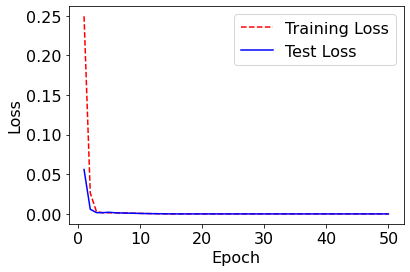

7/7 [==============================] - 0s 2ms/step


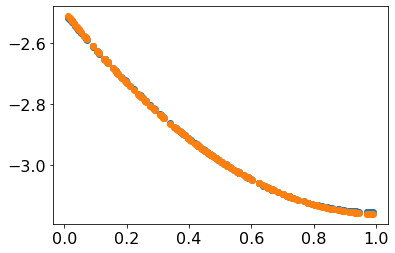

Run Time : 10.702626
7/7 [==============================] - 0s 2ms/step


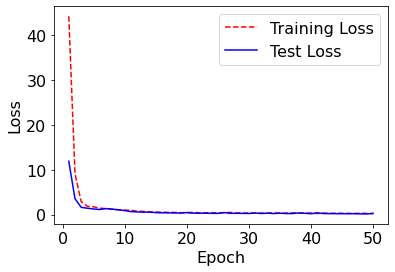

7/7 [==============================] - 0s 2ms/step


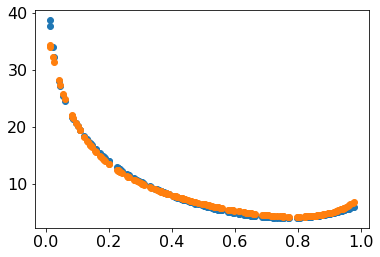

Run Time : 10.512714
7/7 [==============================] - 0s 2ms/step


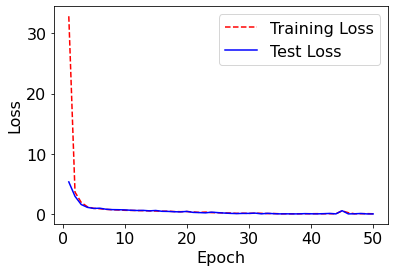

7/7 [==============================] - 0s 2ms/step


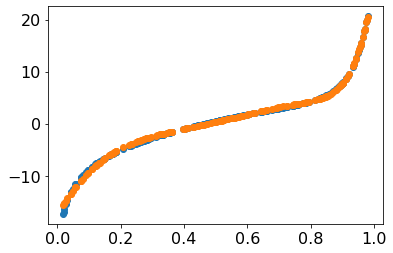

In [44]:
# this code is preparing data, training a model, and then visualizing the results of the model's performance. 
# The data preparation includes reshaping the data into the correct shape for the model and selecting a particular column of the data to use. 
# The model is then trained on this data for a specified number of epochs, and the time it takes to train the model is recorded.
# Finally, the model is used to make predictions on the test set, and the results are visualized.
#   The results of the model's performance, including the test data and predictions, are stored in the F_1_our_model variable.

# Preprocess data
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_our_model = model_training_visualization(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)


# Preprocess data
column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# Train model

F_2_our_model = model_training_visualization(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)


# Preprocess data
column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# Train model

F_3_our_model = model_training_visualization(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)

In [45]:
#Second Traditional model for Function 3
archicture_1 = Sequential()
archicture_1.add(Dense(5, input_dim=input_dim, activation='relu'))
archicture_1.add(Dense(10, activation='relu'))
archicture_1.add(Dense(50, activation='tanh'))
archicture_1.add(Dense(18, activation='relu'))
archicture_1.add(Dense(15, activation='tanh'))
archicture_1.add(Dense(18, activation='sigmoid'))
archicture_1.add(Dropout(0.2))
archicture_1.add(Dense(8, activation='relu'))
archicture_1.add(Dropout(0.2))
archicture_1.add(Dense(output_dim, activation='relu'))
#model.summary()
archicture_1.compile(loss='mean_squared_error', optimizer='adam')

Run Time : 12.087504
7/7 [==============================] - 0s 2ms/step


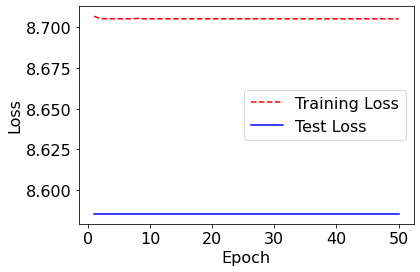

7/7 [==============================] - 0s 2ms/step


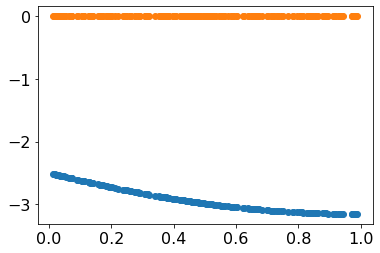

Run Time : 10.569563
7/7 [==============================] - 0s 2ms/step


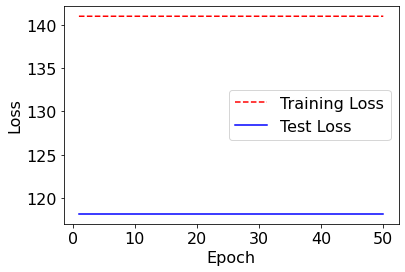

7/7 [==============================] - 0s 2ms/step


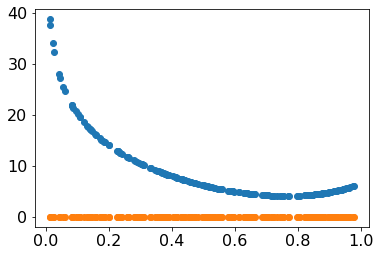

Run Time : 10.589427
7/7 [==============================] - 0s 2ms/step


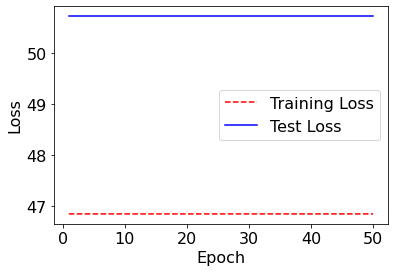

7/7 [==============================] - 0s 2ms/step


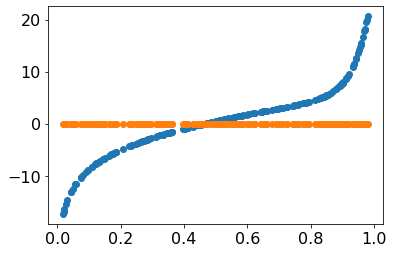

In [46]:
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_archicture_1 = model_training_visualization(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_archicture_1 = model_training_visualization(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_archicture_1 = model_training_visualization(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

In [47]:
#Fifth Traditional Model
archicture_2 = Sequential()
archicture_2.add(Dense(5, input_dim=input_dim, activation='softplus'))
archicture_2.add(Dense(10, activation='softplus'))
archicture_2.add(Dense(20, activation='tanh'))
archicture_2.add(Dense(15, activation='relu'))
archicture_2.add(Dense(25, activation='tanh'))
archicture_2.add(Dense(20, activation='sigmoid'))
archicture_2.add(Dense(25, activation='relu'))
archicture_2.add(Dense(output_dim, activation='softplus'))
archicture_2.add(Dropout(0.2))
archicture_2.compile(loss='mean_squared_error', optimizer='adam')

Run Time : 11.544169
7/7 [==============================] - 0s 2ms/step


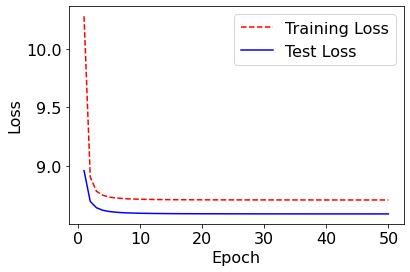

7/7 [==============================] - 0s 2ms/step


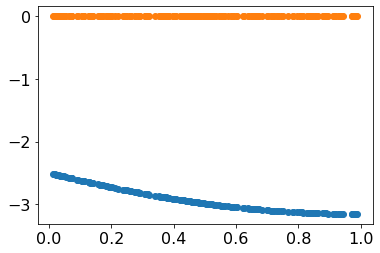

Run Time : 10.858087
7/7 [==============================] - 0s 2ms/step


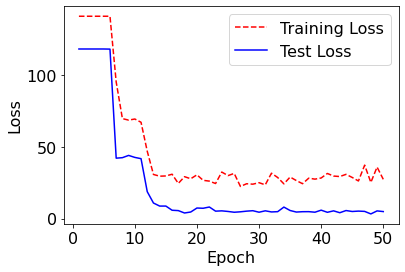

7/7 [==============================] - 0s 2ms/step


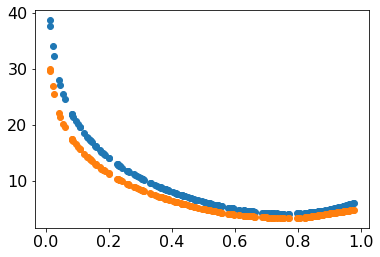

Run Time : 10.969828
7/7 [==============================] - 0s 2ms/step


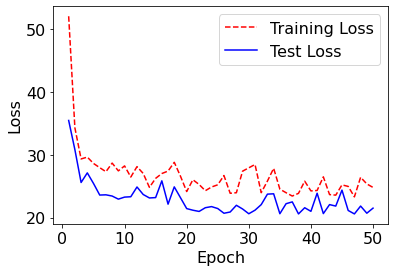

7/7 [==============================] - 0s 2ms/step


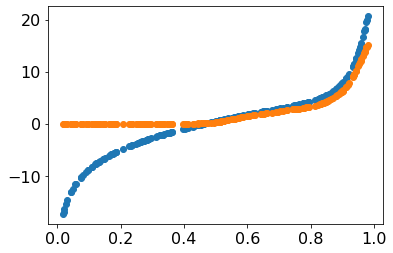

In [48]:
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_archicture_2 = model_training_visualization(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_archicture_2 = model_training_visualization(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_archicture_2 = model_training_visualization(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

Epoch 1/5
25/25 [==============================] - 1s 3ms/step - loss: 137.4511 - mean_squared_error: 137.4511
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 122.7485 - mean_squared_error: 122.7485
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 88.5732 - mean_squared_error: 88.5732
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 37.8251 - mean_squared_error: 37.8251
Epoch 5/5
25/25 [==============================] - 0s 3ms/step - loss: 8.2853 - mean_squared_error: 8.2853
Run Time : 9.076281
7/7 [==============================] - 0s 2ms/step


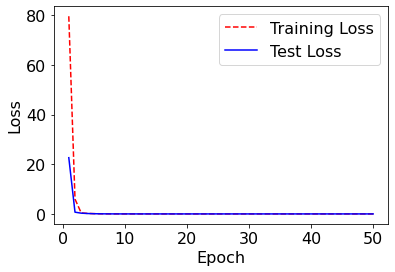

7/7 [==============================] - 0s 2ms/step


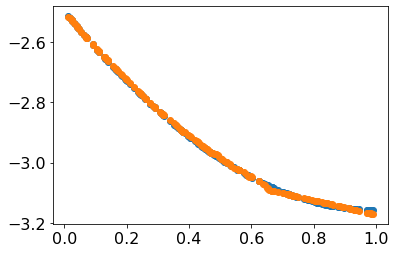

Run Time : 8.645779
7/7 [==============================] - 0s 2ms/step


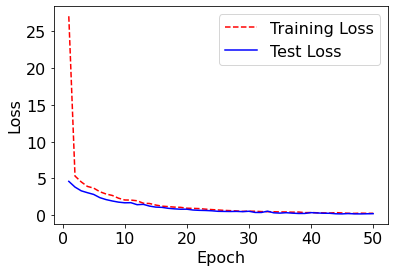

7/7 [==============================] - 0s 2ms/step


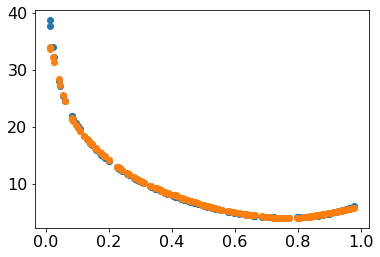

Run Time : 8.673638
7/7 [==============================] - 0s 2ms/step


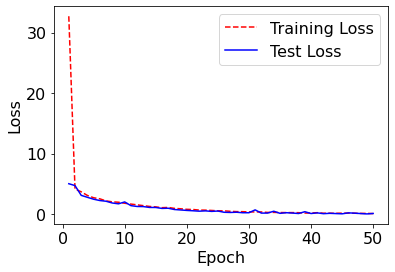

7/7 [==============================] - 0s 2ms/step


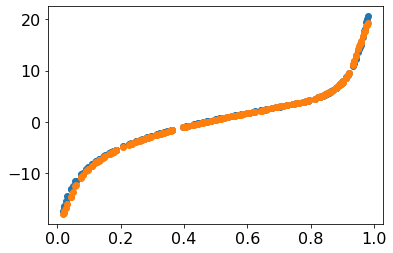

In [49]:
column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_set = tf.data.Dataset.from_tensor_slices(
    (X_test, Y_test)
)

clf = ak.StructuredDataRegressor(
    overwrite=True, max_trials=10
) 
# Feed the tensorflow Dataset to the classifier.
clf.fit(train_set, epochs=5,verbose=0)
autokeras_model=clf.export_model()


column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_autokeras = model_training_visualization(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_autokeras = model_training_visualization(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_autokeras = model_training_visualization(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

In [50]:
# This code performs hyperparameter tuning using grid search cross-validation on a Keras neural network model for regression.
#  The model has three dense layers, with dropout and kernel initializers applied between each layer. 
#  The hyperparameters that are being tuned are the batch size, number of epochs, learning rate, dropout rate, activation functions, kernel initializers,
#   and number of neurons in each layer. The model is trained on the input data X_train and
#   the output data Y_train. The best hyperparameter combination is determined based on mean squared error,
#   which is used as the evaluation metric. The results of the grid search, including the best combination 
#   and the performance of all combinations, are printed to the console. The total runtime of the code is also printed.


def create_best_model(best_param):
    model = Sequential()
    model.add(
        Dense(
            best_param['neuron1'],
            input_dim=1,
            kernel_initializer=best_param['init'],
            activation=best_param['activation_function'],
        )
    )
    model.add(Dropout(best_param['dropout_rate']))
    model.add(
        Dense(
            best_param['neuron2'],
            input_dim=best_param['neuron1'],
            kernel_initializer=best_param['init'],
            activation=best_param['activation_function_1'],
        )
    )
    model.add(Dropout(best_param['dropout_rate']))
    model.add(Dense(1, activation=best_param['activation_function_2']))

    optimizer = tf.keras.optimizers.Adam(learning_rate=best_param['learning_rate'])
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['mse'])
    return model

def create_model(
    learning_rate,
    dropout_rate,
    activation_function,
    activation_function_1,
    activation_function_2,
    init,
    neuron1,
    neuron2,
):
    model = Sequential()
    model.add(
        Dense(
            neuron1,
            input_dim=1,
            kernel_initializer=init,
            activation=activation_function,
        )
    )
    model.add(Dropout(dropout_rate))
    model.add(
        Dense(
            neuron2,
            input_dim=neuron1,
            kernel_initializer=init,
            activation=activation_function_1,
        )
    )
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation_function_2))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['mse'])
    return model


# Create the model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grids = {
    'batch_size': [10],
    'epochs': [10],
    'learning_rate': [0.01],
    'dropout_rate': [0.1],
    'activation_function': ['softmax', 'relu', 'tanh', 'linear'],
    'activation_function_1': ['softmax', 'relu', 'tanh', 'linear'],
    'activation_function_2': ['softmax', 'relu', 'tanh', 'linear'],
    'init': ['uniform'],
    'neuron1': [50, 100, 150],
    'neuron2': [20, 40, 80],
}

start = timeit.default_timer()

# Build and fit the GridSearchCV
kfold = KFold(n_splits=2)
grid = GridSearchCV(estimator=model, param_grid=param_grids, cv=kfold, verbose=0)
grid_result = grid.fit(X_train, Y_train)

# Summarize the results
print(f"Best score: {grid_result.best_score_}, using {grid_result.best_params_}")
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean}, {stdev} with: {param}")

# Print runtime
end = timeit.default_timer()
print("Run Time : %f" % (end-start))


<ipython-input-50-bfd3bda0665b>:73: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best score: -1.8544113636016846, using {'activation_function': 'linear', 'activation_function_1': 'relu', 'activation_function_2': 'linear', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 150, 'neuron2': 40}
-46.72833251953125, 4.958072662353516 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 50, 'neuron2': 20}
-46.72833251953125, 4.958072662353516 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 50, 'neuron2': 40}
-46.72833251953125, 4.958072662353516 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rat

In [51]:
search_model=create_best_model(grid_result.best_params_)

Run Time : 8.499997
7/7 [==============================] - 0s 2ms/step


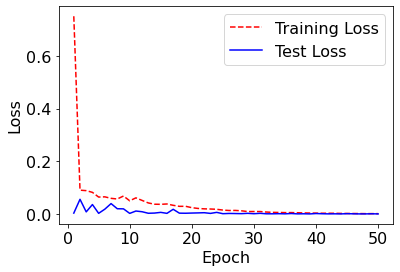

7/7 [==============================] - 0s 2ms/step


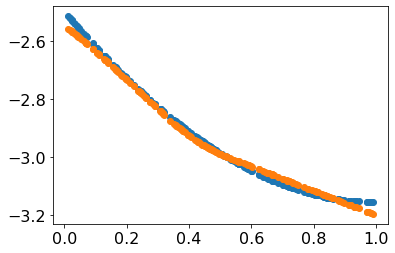

Run Time : 8.158776
7/7 [==============================] - 0s 1ms/step


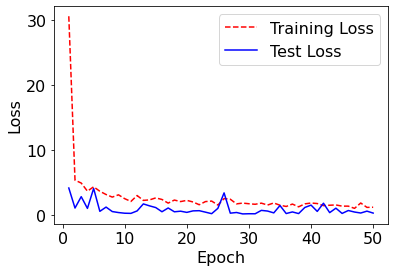

7/7 [==============================] - 0s 2ms/step


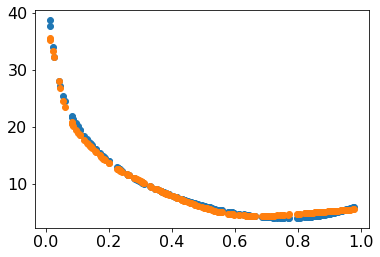

Run Time : 8.150072
7/7 [==============================] - 0s 2ms/step


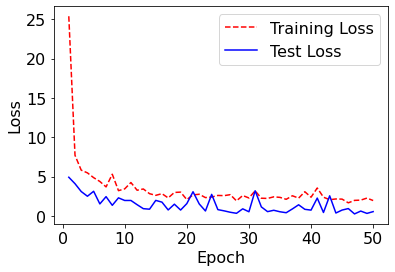

7/7 [==============================] - 0s 2ms/step


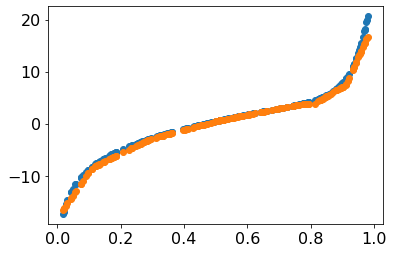

In [52]:



column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_Search = model_training_visualization(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_Search = model_training_visualization(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_Search = model_training_visualization(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

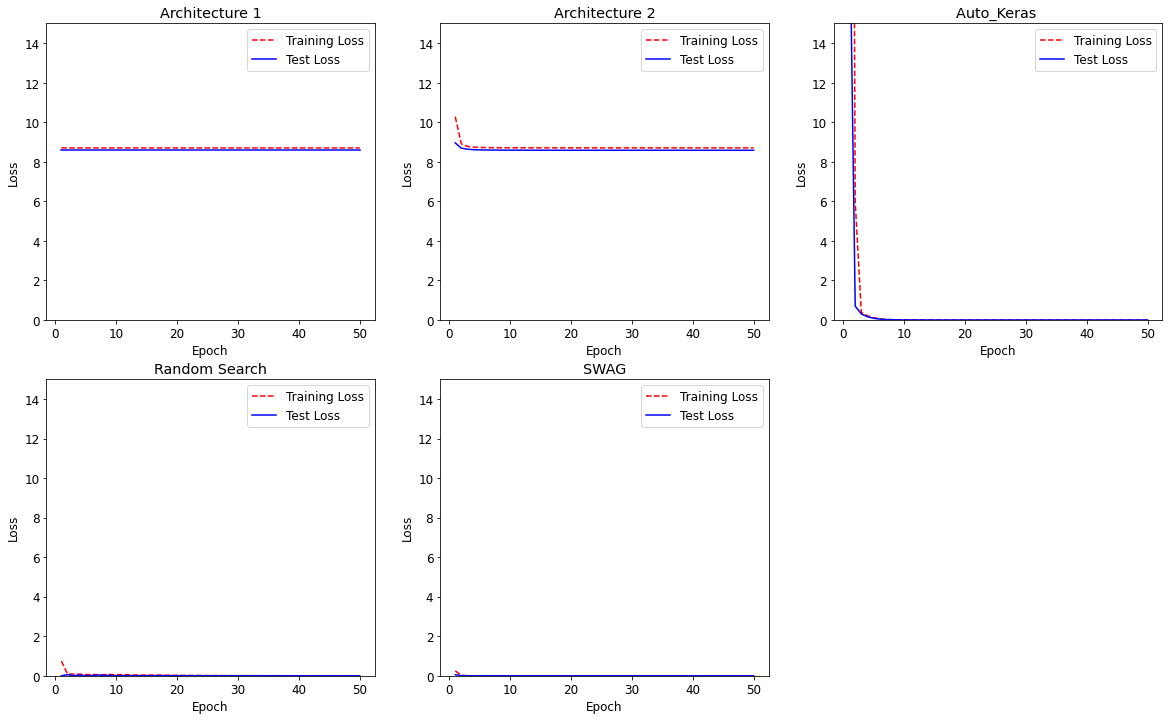

In [53]:
#Plots Losses
plot_loss(15,F_1_archicture_1[3],F_1_archicture_2[3],F_1_autokeras[3],F_1_Search[3],F_1_our_model[3],)

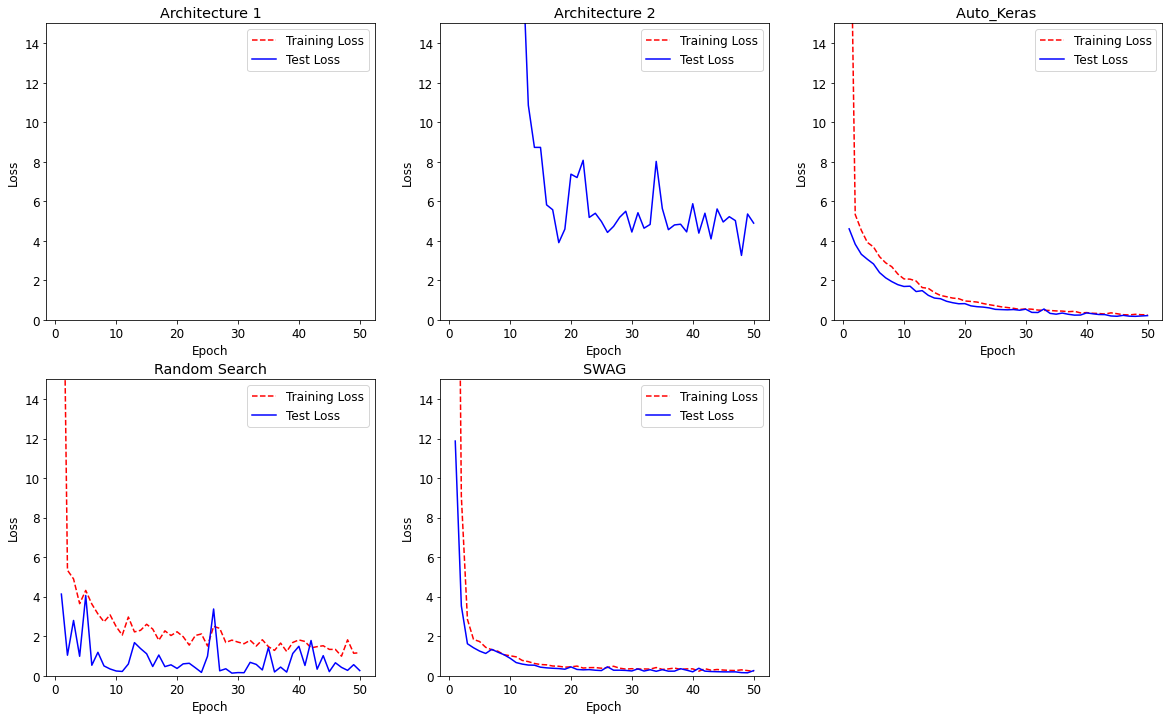

In [54]:
#Plot Losses
plot_loss(15,F_2_archicture_1[3],F_2_archicture_2[3],F_2_autokeras[3],F_2_Search[3],F_2_our_model[3],)

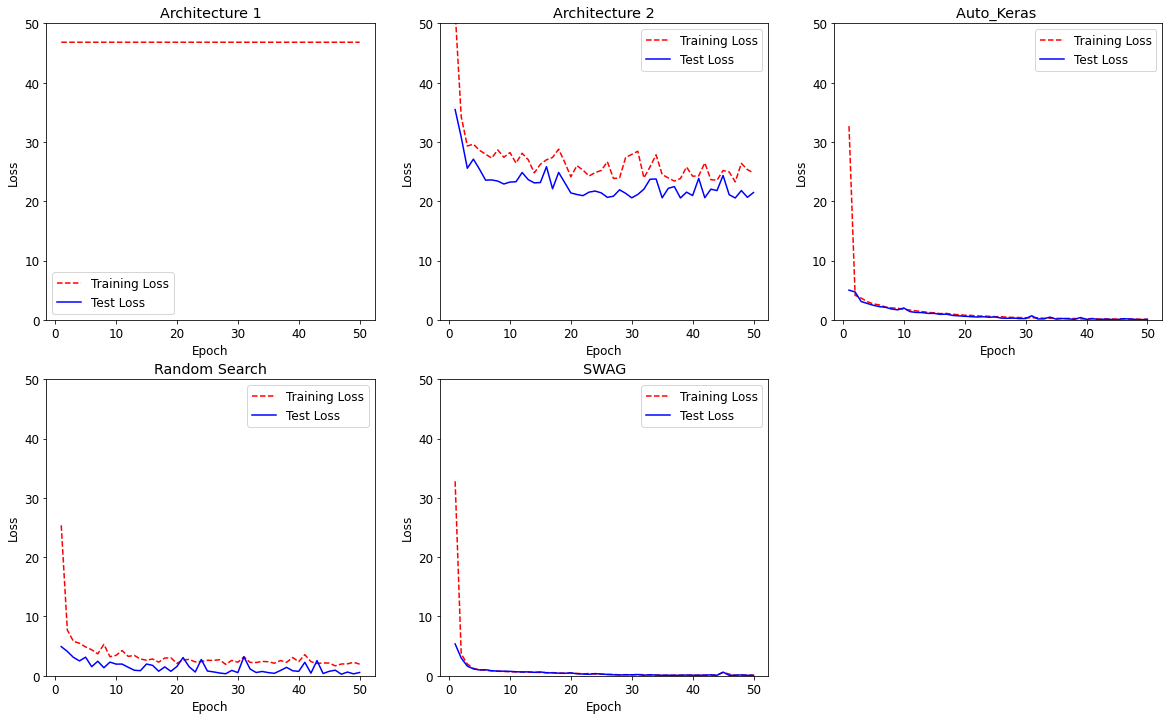

In [55]:
#Plot Losses
plot_loss(50,F_3_archicture_1[3],F_3_archicture_2[3],F_3_autokeras[3],F_3_Search[3],F_3_our_model[3],)

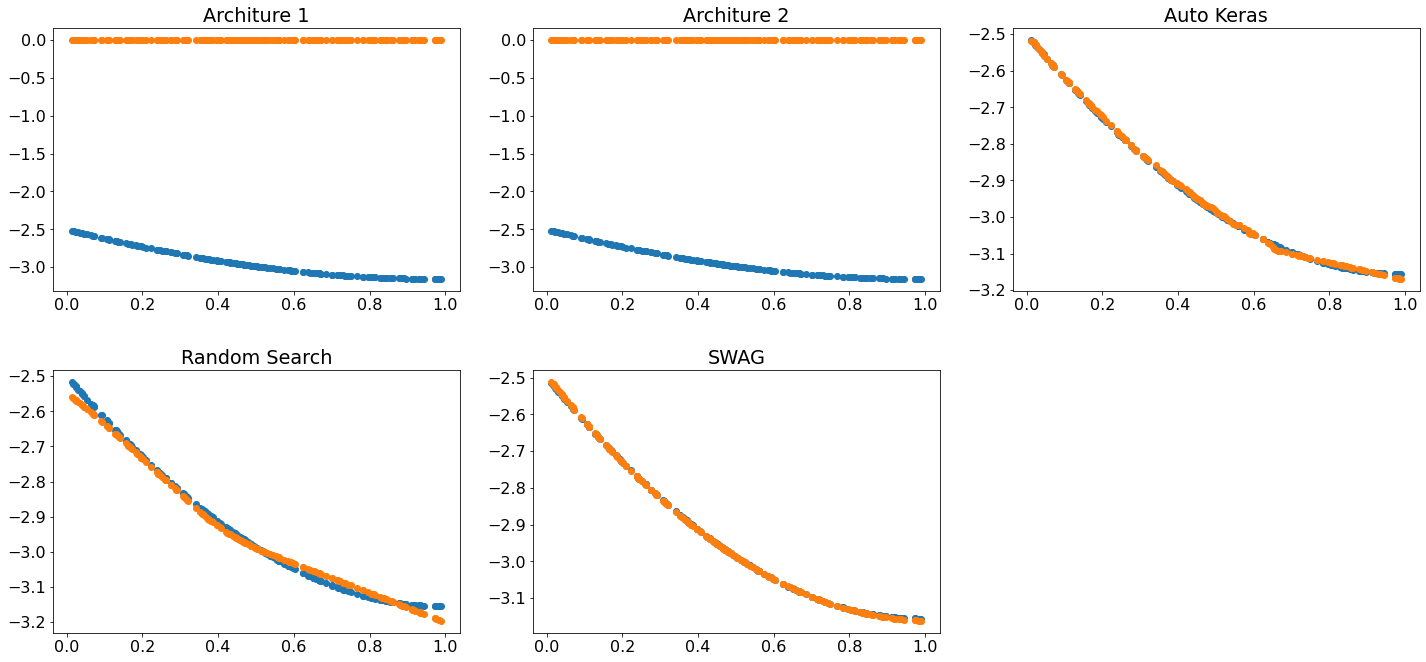

In [56]:
#Plots Shapes
plot_shape(F_1_archicture_1,F_1_archicture_2,F_1_autokeras,F_1_Search,F_1_our_model,)

# plot_loss(15,F_1_archicture_1[3],F_1_archicture_2[3],F_1_autokeras[3],F_1_Search[3],F_1_our_model[3],)

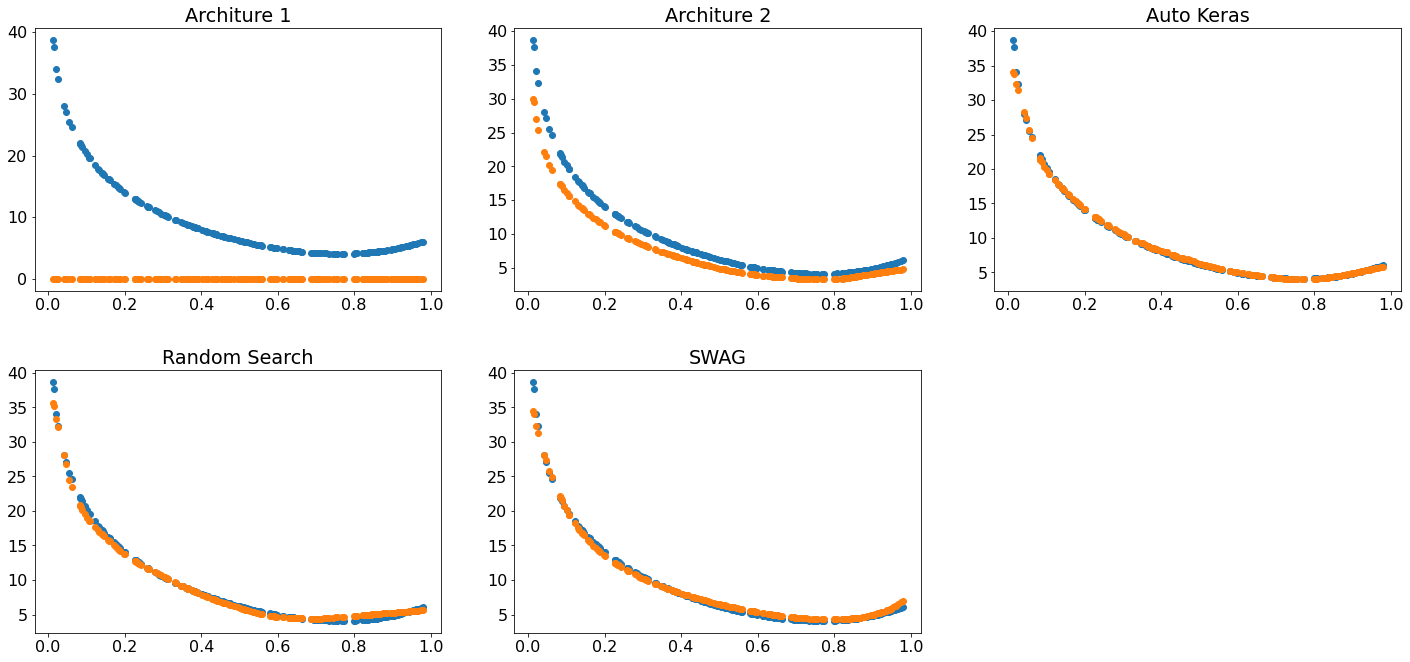

In [57]:
#Plots Shapes 
plot_shape(F_2_archicture_1,F_2_archicture_2,F_2_autokeras,F_2_Search,F_2_our_model,)


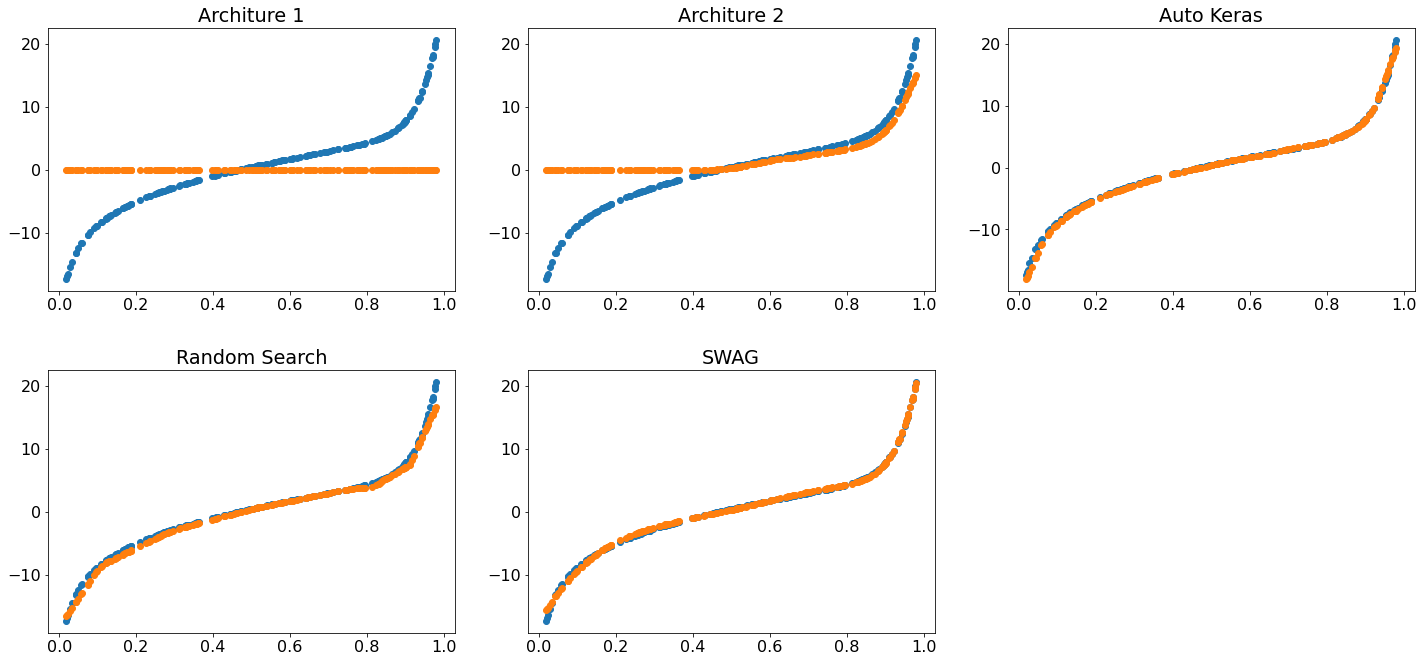

In [58]:
#Plots Shapes
plot_shape(F_3_archicture_1,F_3_archicture_2,F_3_autokeras,F_3_Search,F_3_our_model,)


In [59]:
import random
def rand_list():
  coefficient= [None for _ in range(8)]
  coefficient[0]= random.randint(-10, 10)
  coefficient[2]= random.randint(-10, 10)
  coefficient[4]= random.randint(-10, 10)
  coefficient[6]= random.randint(-10, 10)
  coefficient[1]= random.randint(1,50)
  coefficient[3]= random.randint(1,50)
  coefficient[5]= random.randint(1,50)
  coefficient[7]= random.randint(1,50)
  return coefficient


def fun_generator(co,x):
    return co[0]*power_(x, co[1])+co[2]*sigmoid_array(co[3]*x)+co[4]*exp_(co[5]*x*0.1)+co[6]*log_(co[7]*x)

Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 589.0542 - val_loss: 24.5342
Epoch 2/5
80/80 [==============================] - 0s 3ms/step - loss: 11.7134 - val_loss: 11.7156
Epoch 3/5
80/80 [==============================] - 0s 3ms/step - loss: 6.4857 - val_loss: 7.6934
Epoch 4/5
80/80 [==============================] - 0s 3ms/step - loss: 4.4983 - val_loss: 6.4258
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 4.0331 - val_loss: 6.1448
Run Time : 1.897007


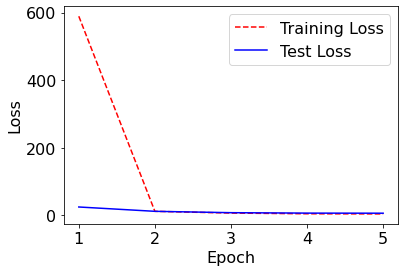

7/7 [==============================] - 0s 2ms/step
SWAG Validation loss :[4.033063888549805]


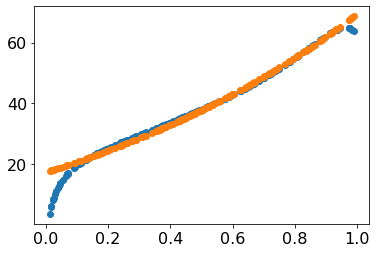

Epoch 1/5
25/25 [==============================] - 1s 3ms/step - loss: 885.3278 - mean_squared_error: 885.3278
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 120.8254 - mean_squared_error: 120.8254
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 72.0035 - mean_squared_error: 72.0035
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 59.8879 - mean_squared_error: 59.8879
Epoch 5/5
25/25 [==============================] - 0s 3ms/step - loss: 54.5828 - mean_squared_error: 54.5828
Run Time : 23.621778


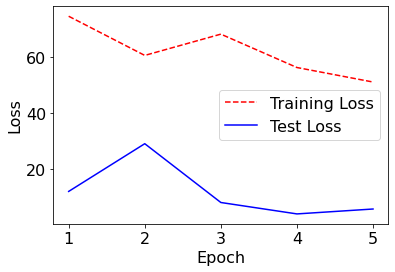

7/7 [==============================] - 0s 2ms/step
Autokeras Validation loss [51.04256820678711]


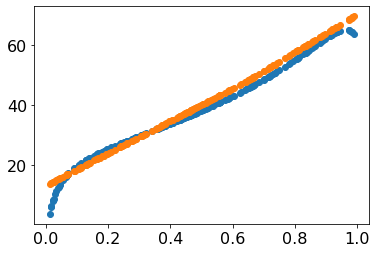

Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 665.7565 - val_loss: 76.9995
Epoch 2/5
80/80 [==============================] - 0s 3ms/step - loss: 50.2752 - val_loss: 39.8612
Epoch 3/5
80/80 [==============================] - 0s 3ms/step - loss: 23.6338 - val_loss: 18.5965
Epoch 4/5
80/80 [==============================] - 0s 3ms/step - loss: 11.3301 - val_loss: 12.4340
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 8.8985 - val_loss: 10.4620
Run Time : 1.860749


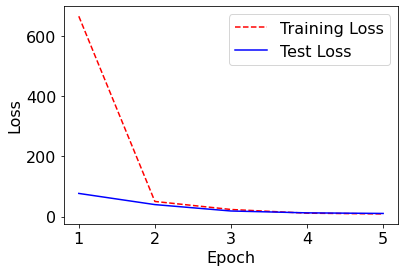

7/7 [==============================] - 0s 2ms/step
SWAG Validation loss :[8.898519515991211]


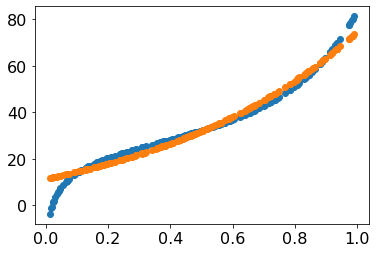

Epoch 1/5
25/25 [==============================] - 0s 3ms/step - loss: 647.2458 - mean_squared_error: 647.2458
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 59.3183 - mean_squared_error: 59.3183
Epoch 3/5
25/25 [==============================] - 0s 4ms/step - loss: 27.5216 - mean_squared_error: 27.5216
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 18.6213 - mean_squared_error: 18.6213
Epoch 5/5
25/25 [==============================] - 0s 3ms/step - loss: 15.8692 - mean_squared_error: 15.8692
Run Time : 21.654793


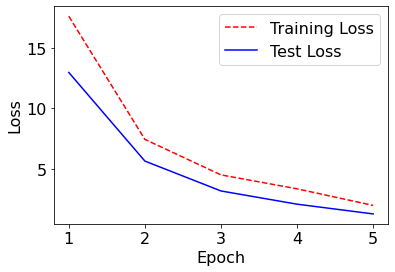

7/7 [==============================] - 0s 2ms/step
Autokeras Validation loss [1.95720636844635]


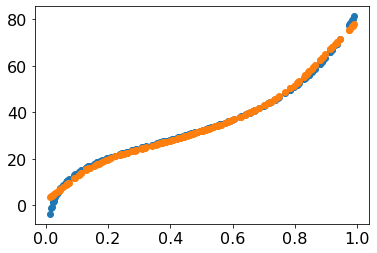

Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 2532.8936 - val_loss: 984.5765
Epoch 2/5
80/80 [==============================] - 0s 3ms/step - loss: 783.1403 - val_loss: 577.2907
Epoch 3/5
80/80 [==============================] - 0s 3ms/step - loss: 441.6081 - val_loss: 284.3889
Epoch 4/5
80/80 [==============================] - 0s 3ms/step - loss: 174.8867 - val_loss: 88.9332
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 50.2995 - val_loss: 33.7708
Run Time : 1.894714


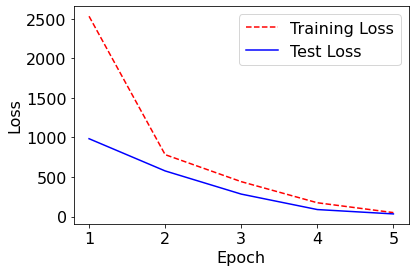

7/7 [==============================] - 0s 2ms/step
SWAG Validation loss :[50.29948425292969]


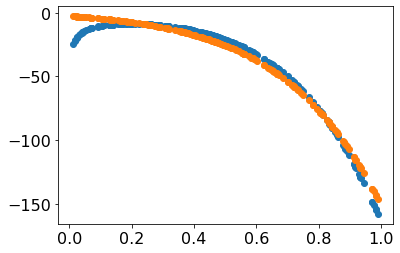

Epoch 1/5
25/25 [==============================] - 0s 3ms/step - loss: 3062.2666 - mean_squared_error: 3062.2666
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 918.4629 - mean_squared_error: 918.4629
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 127.8218 - mean_squared_error: 127.8218
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 75.4856 - mean_squared_error: 75.4856
Epoch 5/5
25/25 [==============================] - 0s 3ms/step - loss: 63.0990 - mean_squared_error: 63.0990
Run Time : 23.435564


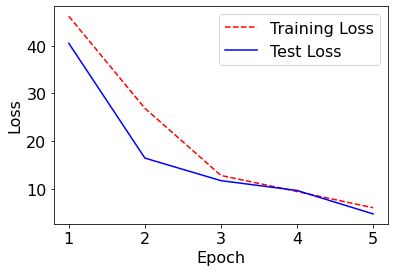

7/7 [==============================] - 0s 2ms/step
Autokeras Validation loss [6.032337188720703]


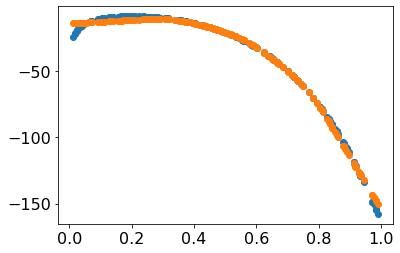

Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 298.7927 - val_loss: 26.3200
Epoch 2/5
80/80 [==============================] - 0s 3ms/step - loss: 15.6435 - val_loss: 21.2070
Epoch 3/5
80/80 [==============================] - 0s 3ms/step - loss: 14.6126 - val_loss: 20.5873
Epoch 4/5
80/80 [==============================] - 0s 3ms/step - loss: 14.4890 - val_loss: 20.0134
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 14.2689 - val_loss: 19.7890
Run Time : 1.873173


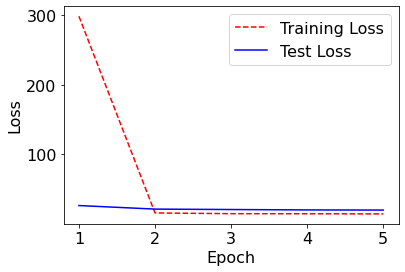

7/7 [==============================] - 0s 2ms/step
SWAG Validation loss :[14.268913269042969]


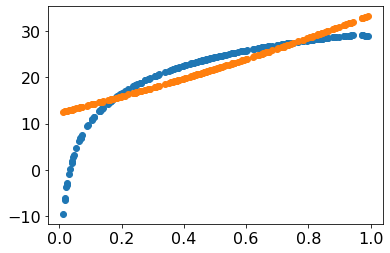

Epoch 1/5
25/25 [==============================] - 0s 3ms/step - loss: 453.4463 - mean_squared_error: 453.4463
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 124.7150 - mean_squared_error: 124.7150
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 19.1858 - mean_squared_error: 19.1858
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 14.4073 - mean_squared_error: 14.4073
Epoch 5/5
25/25 [==============================] - 0s 3ms/step - loss: 14.2245 - mean_squared_error: 14.2245
Run Time : 21.687507


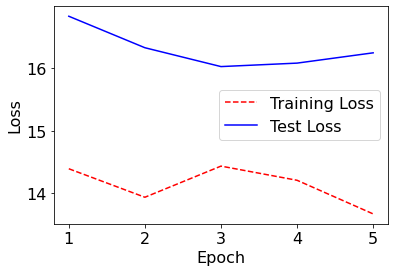

7/7 [==============================] - 0s 2ms/step
Autokeras Validation loss [13.672601699829102]


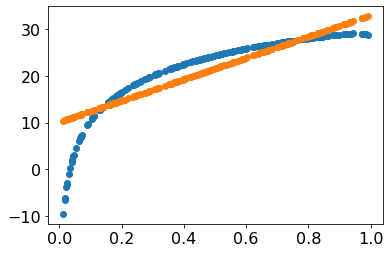

Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 23283.8633 - val_loss: 10636.9404
Epoch 2/5
80/80 [==============================] - 0s 3ms/step - loss: 7424.5386 - val_loss: 5670.3657
Epoch 3/5
80/80 [==============================] - 0s 3ms/step - loss: 4389.4863 - val_loss: 2965.1804
Epoch 4/5
80/80 [==============================] - 0s 3ms/step - loss: 2030.2325 - val_loss: 1170.4778
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 683.9448 - val_loss: 314.9478
Run Time : 1.861905


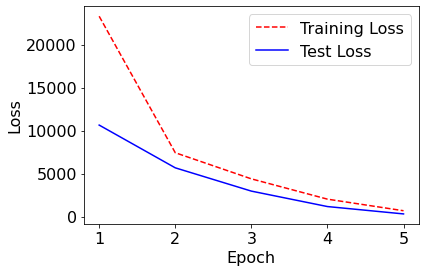

7/7 [==============================] - 0s 2ms/step
SWAG Validation loss :[683.94482421875]


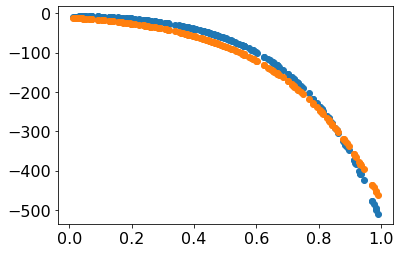

Epoch 1/5
25/25 [==============================] - 0s 3ms/step - loss: 16387.2676 - mean_squared_error: 16387.2676
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 1334.1567 - mean_squared_error: 1334.1567
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 730.2157 - mean_squared_error: 730.2157
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 403.9852 - mean_squared_error: 403.9852
Epoch 5/5
25/25 [==============================] - 0s 3ms/step - loss: 237.0275 - mean_squared_error: 237.0275
Run Time : 22.637345


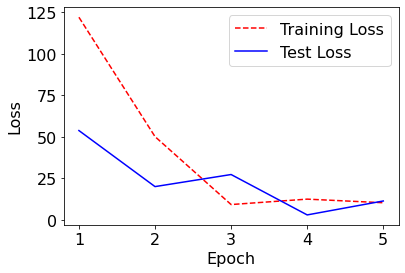

7/7 [==============================] - 0s 2ms/step
Autokeras Validation loss [10.285368919372559]


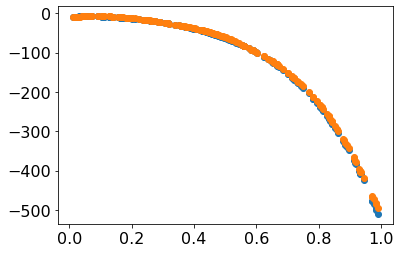

Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 13649.0166 - val_loss: 5716.4795
Epoch 2/5
80/80 [==============================] - 0s 3ms/step - loss: 4469.7402 - val_loss: 3291.6826
Epoch 3/5
80/80 [==============================] - 0s 3ms/step - loss: 2326.2034 - val_loss: 1537.9911
Epoch 4/5
80/80 [==============================] - 0s 3ms/step - loss: 917.8602 - val_loss: 513.7288
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 250.5767 - val_loss: 97.6997
Run Time : 1.859268


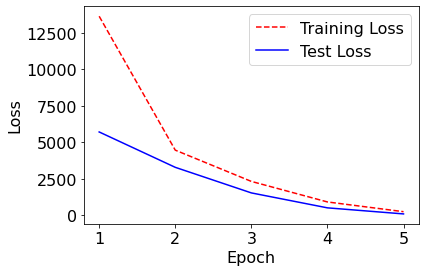

7/7 [==============================] - 0s 2ms/step
SWAG Validation loss :[250.5767364501953]


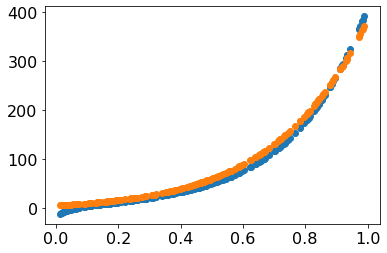

Epoch 1/5
25/25 [==============================] - 1s 3ms/step - loss: 18643.0703 - mean_squared_error: 18643.0703
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 17244.9941 - mean_squared_error: 17244.9941
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 13563.6211 - mean_squared_error: 13563.6211
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 7260.3965 - mean_squared_error: 7260.3965
Epoch 5/5
25/25 [==============================] - 0s 3ms/step - loss: 2388.4834 - mean_squared_error: 2388.4834
Run Time : 23.122582


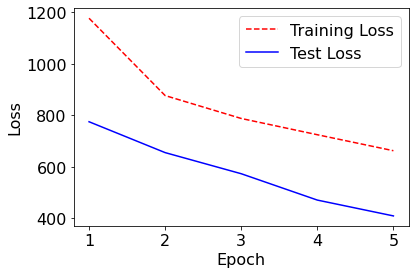

7/7 [==============================] - 0s 2ms/step
Autokeras Validation loss [662.424560546875]


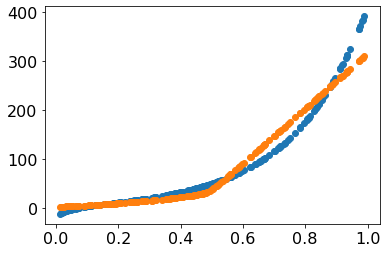

Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 15584.7266 - val_loss: 7317.2729
Epoch 2/5
80/80 [==============================] - 0s 3ms/step - loss: 4943.3252 - val_loss: 3731.5537
Epoch 3/5
80/80 [==============================] - 0s 3ms/step - loss: 2773.6582 - val_loss: 1875.6774
Epoch 4/5
80/80 [==============================] - 0s 3ms/step - loss: 1263.4584 - val_loss: 721.3984
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 413.6768 - val_loss: 191.2755
Run Time : 1.855674


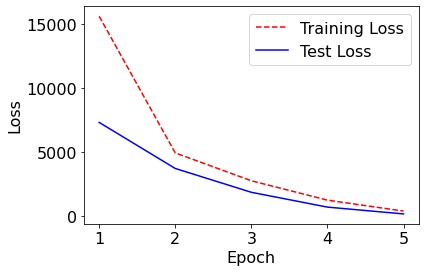

7/7 [==============================] - 0s 2ms/step
SWAG Validation loss :[413.6768493652344]


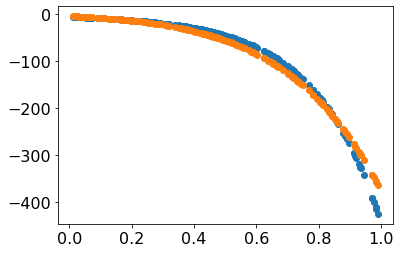

Epoch 1/5
25/25 [==============================] - 0s 3ms/step - loss: 18104.0996 - mean_squared_error: 18104.0996
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 9470.2988 - mean_squared_error: 9470.2988
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 4715.8530 - mean_squared_error: 4715.8530
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 5329.8281 - mean_squared_error: 5329.8281
Epoch 5/5
25/25 [==============================] - 0s 3ms/step - loss: 2340.4104 - mean_squared_error: 2340.4104
Run Time : 21.822848


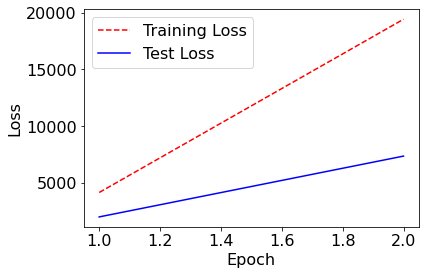

7/7 [==============================] - 0s 2ms/step
Autokeras Validation loss [nan]


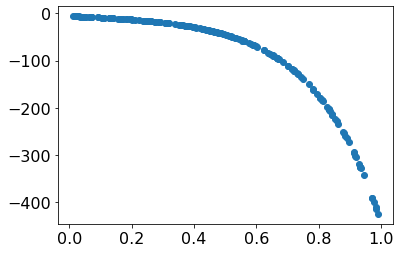

Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 34.4562 - val_loss: 28.6887
Epoch 2/5
80/80 [==============================] - 0s 3ms/step - loss: 26.9563 - val_loss: 22.2545
Epoch 3/5
80/80 [==============================] - 0s 3ms/step - loss: 16.6031 - val_loss: 11.2582
Epoch 4/5
80/80 [==============================] - 0s 3ms/step - loss: 8.0710 - val_loss: 8.4562
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 5.7098 - val_loss: 6.1115
Run Time : 1.867744


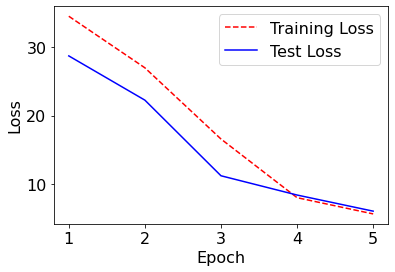

7/7 [==============================] - 0s 2ms/step
SWAG Validation loss :[5.709784507751465]


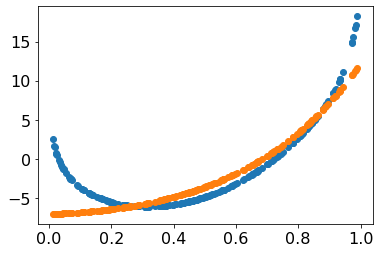

Epoch 1/5
25/25 [==============================] - 0s 3ms/step - loss: 30.7563 - mean_squared_error: 30.7563
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 26.9787 - mean_squared_error: 26.9787
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 22.1596 - mean_squared_error: 22.1596
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 16.5067 - mean_squared_error: 16.5067
Epoch 5/5
25/25 [==============================] - 0s 3ms/step - loss: 11.9691 - mean_squared_error: 11.9691
Run Time : 22.419944


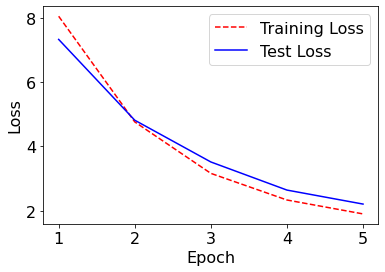

7/7 [==============================] - 0s 2ms/step
Autokeras Validation loss [1.9037359952926636]


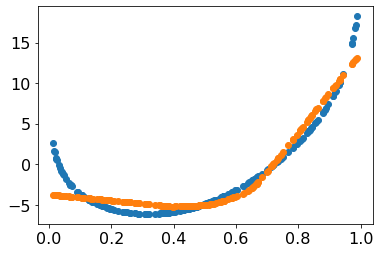

Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 7785.1436 - val_loss: 3166.6062
Epoch 2/5
80/80 [==============================] - 0s 3ms/step - loss: 2195.4395 - val_loss: 1675.7527
Epoch 3/5
80/80 [==============================] - 0s 3ms/step - loss: 1281.1219 - val_loss: 881.3321
Epoch 4/5
80/80 [==============================] - 0s 3ms/step - loss: 612.7552 - val_loss: 397.5090
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 258.3421 - val_loss: 217.7017
Run Time : 1.890833


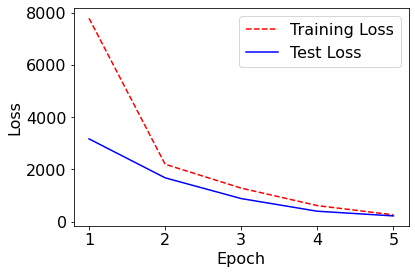

7/7 [==============================] - 0s 2ms/step
SWAG Validation loss :[258.34210205078125]


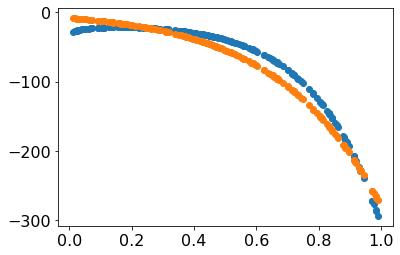

Epoch 1/5
25/25 [==============================] - 0s 3ms/step - loss: 4753.5454 - mean_squared_error: 4753.5454
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 2972.7351 - mean_squared_error: 2972.7351
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 2307.1575 - mean_squared_error: 2307.1575
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 1382.0302 - mean_squared_error: 1382.0302
Epoch 5/5
25/25 [==============================] - 0s 4ms/step - loss: 2140.7769 - mean_squared_error: 2140.7769
Run Time : 23.198473


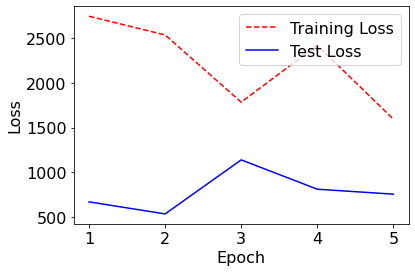

7/7 [==============================] - 0s 2ms/step
Autokeras Validation loss [1594.2545166015625]


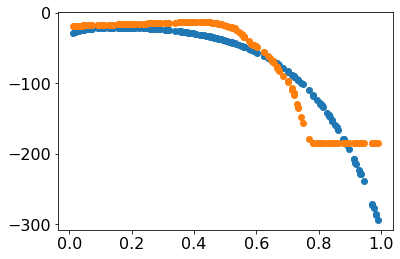

Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 36.9829 - val_loss: 16.4059
Epoch 2/5
80/80 [==============================] - 0s 3ms/step - loss: 10.6006 - val_loss: 14.1255
Epoch 3/5
80/80 [==============================] - 0s 3ms/step - loss: 9.5602 - val_loss: 12.8831
Epoch 4/5
80/80 [==============================] - 0s 3ms/step - loss: 9.1594 - val_loss: 12.2190
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 8.8649 - val_loss: 11.8107
Run Time : 1.878872


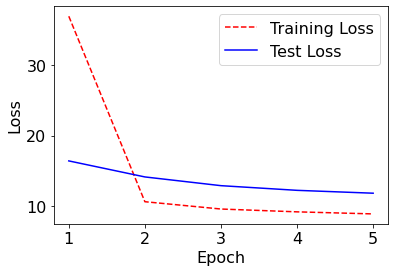

7/7 [==============================] - 0s 2ms/step
SWAG Validation loss :[8.864912986755371]


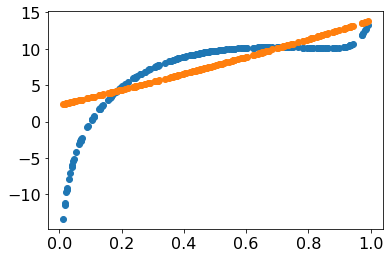

Epoch 1/5
25/25 [==============================] - 1s 3ms/step - loss: 19.2744 - mean_squared_error: 19.2744
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 10.0319 - mean_squared_error: 10.0319
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 9.5449 - mean_squared_error: 9.5449
Epoch 4/5
25/25 [==============================] - 0s 3ms/step - loss: 9.8714 - mean_squared_error: 9.8714
Epoch 5/5
25/25 [==============================] - 0s 3ms/step - loss: 10.3088 - mean_squared_error: 10.3088
Run Time : 21.699984


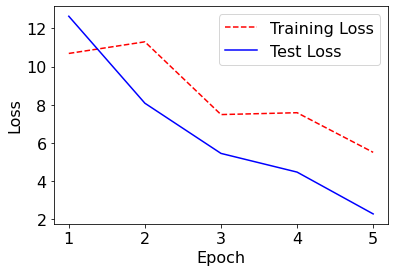

7/7 [==============================] - 0s 2ms/step
Autokeras Validation loss [5.498445987701416]


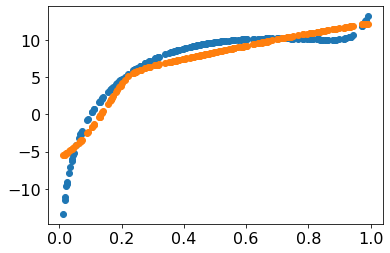

In [60]:
hidden_dimention = 50

for kk in range(10):  
  coefficient=rand_list()
  X1=X[:,0]
  Y1=fun_generator(coefficient,X1)
  X_train,X_test,Y_train,Y_test=train_test_split(X1,Y1,test_size=0.2,random_state=1234)

  Our_model=SWAG()
  coefficient=rand_list()
  start = timeit.default_timer()
  SWAG_history = Our_model.fit(X_train,Y_train,epochs=5,verbose=1,batch_size=10,validation_data=(X_test, Y_test)) 
  end = timeit.default_timer()
  print("Run Time : %f" % (end-start))
  plot_(SWAG_history)
  plt.scatter(X_test, Y_test)
  predict=Our_model.predict(X_test)
  plt.scatter(X_test, predict)
  print("SWAG Validation loss :"+str( SWAG_history.history['loss'][-1:]))
  # MSE = np.square(np.subtract(Y_train,predict)).mean()
  # print(MSE)
  plt.show()


  # Reshape data
  X_train = X_train.reshape(800, 1)
  Y_train = Y_train.reshape(800, 1)
  X_test = X_test.reshape(200, 1)
  Y_test = Y_test.reshape(200, 1)

  train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
  test_set = tf.data.Dataset.from_tensor_slices(
      (X_test, Y_test)
  )

  start = timeit.default_timer()


  clf = ak.StructuredDataRegressor(
      overwrite=True, max_trials=10
  ) 
  # Feed the tensorflow Dataset to the classifier.
  clf.fit(train_set, epochs=5,verbose=0)
  autokeras_model=clf.export_model()

  auto_history = autokeras_model.fit(X_train,Y_train,epochs=5,verbose=0,batch_size=10,validation_data=(X_test, Y_test)) 
  end = timeit.default_timer()
  print("Run Time : %f" % (end-start))
  plot_(auto_history)
  plt.scatter(X_test, Y_test)
  predict=autokeras_model.predict(X_test)
  plt.scatter(X_test, predict)
  print("Autokeras Validation loss "+str( auto_history.history['loss'][-1:]))
  # MSE = np.square(np.subtract(Y_train,predict)).mean()
  # print(MSE)
  plt.show()

In [71]:
batch_size = 128
num_classes = 10
epochs = 4

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train+10
x_test = x_test+10

x_train /= 300
x_test /= 300
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

number_train=60000 
number_test=10000

x_train=x_train[0:number_train,:]
x_test=x_test[0:number_test,:]

y_train=y_train[0:number_train]
y_test=y_test[0:number_test]

60000 train samples
10000 test samples


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 500)          392500      ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 500)          392500      ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 1000)         0           ['dense_3[0][0]',                
                                                                  'dense_4[0][0]']          

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


469/469 [==============================] - 2s 4ms/step - loss: 0.0528 - accuracy: 0.8931 - val_loss: 0.0193 - val_accuracy: 0.9587
Epoch 2/4
469/469 [==============================] - 2s 3ms/step - loss: 0.0151 - accuracy: 0.9676 - val_loss: 0.0129 - val_accuracy: 0.9729
Epoch 3/4
469/469 [==============================] - 2s 3ms/step - loss: 0.0116 - accuracy: 0.9784 - val_loss: 0.0122 - val_accuracy: 0.9761
Epoch 4/4
469/469 [==============================] - 2s 3ms/step - loss: 0.0097 - accuracy: 0.9836 - val_loss: 0.0105 - val_accuracy: 0.9801
7.339685520993953
Test loss: 0.010460824705660343
Test accuracy: 0.9800999760627747


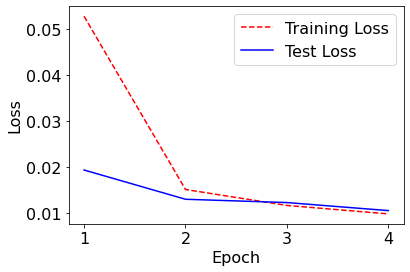

In [72]:
#Our Model optimize version
hidden_dimention=500
model = Sequential()

in_ = Input(shape=(784,))
Layer_1_X_1=Dense(hidden_dimention, activation='X_1')(in_)
################################################################
Layer_1_X_2=Dense(hidden_dimention, activation='X_2')(in_)
###############################################################
Concatenate_First_Layer = concatenate([Layer_1_X_1,Layer_1_X_2])

Layer__X_3_X_4=Dense(hidden_dimention, activation='X_2_')(Concatenate_First_Layer)
###############################################################


Concatenate_second_Layer = concatenate([Layer_1_X_1,Layer_1_X_2,Concatenate_First_Layer,Layer__X_3_X_4])

Out_put_first_layer=Dense(hidden_dimention, activation='linear')(Concatenate_second_Layer)


Out_put=Dense(10, activation='linear')(Out_put_first_layer)
model = Model(in_ , Out_put)
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')



optimizer =Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['accuracy'])
# Image(filename='model_2_layers.png')

start = timeit.default_timer()
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, y_test))
end = timeit.default_timer()
print(end-start)


score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_(history)

In [73]:

start = timeit.default_timer()

clf = ak.StructuredDataClassifier(overwrite=True, max_trials=3) 
clf.fit(x_train, y_train, epochs=5)
scores = clf.evaluate(x_test, y_test, verbose=0)

end = timeit.default_timer()
print("Run Time : %f" % (end-start))

Trial 3 Complete [00h 36m 36s]
val_accuracy: 0.8735833168029785

Best val_accuracy So Far: 0.8736666440963745
Total elapsed time: 01h 49m 18s
Epoch 1/5
1875/1875 [==============================] - 157s 78ms/step - loss: 0.6859 - accuracy: 0.7870
Epoch 2/5
1875/1875 [==============================] - 143s 76ms/step - loss: 0.4094 - accuracy: 0.8725
Epoch 3/5
1875/1875 [==============================] - 147s 79ms/step - loss: 0.3421 - accuracy: 0.8935
Epoch 4/5
1875/1875 [==============================] - 151s 81ms/step - loss: 0.2985 - accuracy: 0.9070
Epoch 5/5
1875/1875 [==============================] - 152s 81ms/step - loss: 0.2673 - accuracy: 0.9153
Run Time : 9574.520065


Test loss: 0.010460824705660343
Test accuracy: 0.9800999760627747


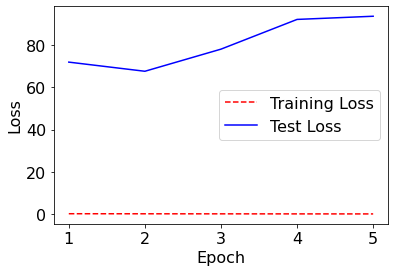

In [74]:
autokeras_model=clf.export_model()

auto_history = autokeras_model.fit(x_train,y_train,epochs=5,verbose=0,batch_size=10,validation_data=(x_test, y_test)) 

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_(auto_history)